 - probeset to gene - just some info about genes
 
Questions:
 - what do we do about NA values
 - the indices are not the same for the dataset and the class file
 - how do we handle samples that are not in the dataset (due to the bags)
 - are repeats separate or distinct samples?

oobs says which indices are in the training set and which that aren't

In [19]:
# ALL classification based on tensorflow
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import tensorflow as tf

import glob


DATASET_TYPE = 'SNP'
# DATASET_TYPE = 'AFFY'


DATASET_PATHS = {
    'SNP': {
        'data_file': "./ds9_snp.csv",
        'clas_file': "./ds9_class.csv"
    },
    'AFFY': {
        'data_file': "./ds9_affy_u133x_hg1st.csv",
        'clas_file': "./ds9_class.csv"
    }
}


# load dataset
# -------------

# (gene, patient-id) = gene presence
Data_File = DATASET_PATHS[DATASET_TYPE]['data_file']

# (patient-id, gender, dob, death, mortality, age, relapse, 
#  Chrom_structure, MRD_based_risk, IsPatient, platform, u133a, u133a2, u133plus2, hg1st)
Clas_File = DATASET_PATHS[DATASET_TYPE]['clas_file']


iData = pd.read_csv(Data_File)
iClas = pd.read_csv(Clas_File)


Dat = iData.iloc[:,1:].as_matrix()
Dat = Dat.astype(np.float32)

# Relapse
Rel = iClas.iloc[:,6].as_matrix()
Rel[Rel=='Yes'] = 1
Rel[Rel=='No'] = 0
Rel = Rel.astype(np.int32)

# Mortality
Mrt = iClas.iloc[:,4].as_matrix()
Mrt[Mrt=='Y'] = 1
Mrt[Mrt=='N'] = 0
Mrt = Mrt.astype(np.int32)

Plt = iClas.iloc[:,10].as_matrix()

Pat = iClas.iloc[:,0].as_matrix()

n_sample, n_feature = Dat.shape

Rel = Rel.reshape(len(Rel), 1)
# Rel = np.concatenate((Rel, (1-Rel)), axis=1)

Mrt = Mrt.reshape(len(Mrt), 1)

# load bags
# bags = pd.read_csv("Dataset/bags.csv").as_matrix()
# oobs = pd.read_csv("Dataset/oobs.csv").as_matrix()

# bag: (gene, mortality)
def load_bags():
    bags = []
    for bag in glob.glob("{}_Bags/bag_*".format(DATASET_TYPE)):
        matrix = pd.read_csv(bag).as_matrix()
        bags.append(matrix)
    return np.asarray(bags)
    
bags = load_bags()

def load_oobs():
    oobs = []
    for oob in glob.glob("{}_Bags/oob_*".format(DATASET_TYPE)):
        matrix = pd.read_csv(oob).as_matrix()
        oobs.append(matrix)
    return np.asarray(oobs)

oobs = load_oobs()


print("Training for dataset {}".format(DATASET_TYPE))

Training for dataset SNP


In [20]:
import sys
print("Dat")
# (row, col)
# print("(n_sample, n_feature)")
print("(patient, gene) = gene presence")
print(Dat.shape)
print("")

print("bags")
print("(bag, patient, mortality)")
print(bags.shape)
print("")


nbag = np.arange(5)
# nbag = np.arange(bags.shape[0])
print("Training with {} bags".format(nbag.shape[0]))

patient_genes_mx = iData.iloc[:,:].as_matrix()

def patient_id_strip(id_):
#     try:
#         list(patient_identifiers).index(id_)
#         return id_
#     except:
    return id_.split('.')[0]


patient_identifiers = list(patient_genes_mx[:, 0])
print("Found {} unique patients".format(len(patient_identifiers)))

Dat
(patient, gene) = gene presence
(141, 17908)

bags
(bag, patient, mortality)
(50, 164, 2)

Training with 5 bags
Found 141 unique patients


In [21]:
patients_sample_tr = np.vstack(bags[nbag])
patients_sample_te = np.vstack(oobs[nbag])

# Remove all with mortality = N
patients_sample_te = patients_sample_te[np.where(patients_sample_te[:, 1] != 0)[0]]


print("Training with {} samples (repeats included)".format(patients_sample_tr.shape[0]))
print("Testing with {} samples (repeats included)".format(patients_sample_te.shape[0]))

def objarr_to_ndarray(objarr):
#     print(objarr[:,0].dtype)
    return np.vstack(objarr).astype('float32')


class PatientNotFoundInDataset(Exception):
    pass

def get_patient_idx_in_dataset(patient_id):
    try:
        i = patient_identifiers.index(patient_id)
        i = patient_identifiers.index(patient_id_strip(patient_id))
        return i
    except:
        #print("Patient not found: {}".format(patient_id))
        return None

def get_patient_idx_in_clas(patient_id):
    return list(iClas.iloc[:,0].as_matrix()).index(patient_id_strip(patient_id))


def remove_nones(L):
    return [x for x in L if x is not None]

# def get_patient_idx(patient_id):
#     v = get_patient_indexes([patient_id])
#     if len(v) == 0:
#         raise PatientNotFoundInDataset()
#     else:
#         return v[0]
    
# def get_patient_indexes(patient_ids):
#     return np.where(patient_identifiers == map(lambda x: [patient_id_strip(x)], patient_ids) )[1]

patients_ixs_tr_all = map(get_patient_idx_in_dataset, list(patients_sample_tr[:,0]))
patients_ixs_tr = remove_nones(patients_ixs_tr_all)

patients_ixs_te_all = map(get_patient_idx_in_dataset, list(patients_sample_te[:,0]))
patients_ixs_te = remove_nones(patients_ixs_te_all)

# X = (patient, gene, strength)
# Y = (patient, mortality)

X_tr = objarr_to_ndarray(patient_genes_mx[patients_ixs_tr][:, 1:]) # ignore patient column
y_tr = Mrt[patients_ixs_tr]

X_te = objarr_to_ndarray(patient_genes_mx[patients_ixs_te][:, 1:])
y_te = Mrt[patients_ixs_te]


# X_tr = Dat[bags[:, nbag-1]]
# y_tr = Mrt[bags[:, nbag-1]]

# X_te = Dat[oobs[:, nbag] == 0]
# y_te = Mrt[oobs[:, nbag] == 0]

print("XY train: ", X_tr.shape, y_tr.shape)
print("XY test: ", X_te.shape, y_te.shape)

Training with 820 samples (repeats included)
Testing with 43 samples (repeats included)
XY train:  (717, 17908) (717, 1)
XY test:  (24, 17908) (24, 1)


In [22]:
# print(X_tr[0,5435]) is NA (NaN value)

# Change "NA" to 0
# TODO: clarify
X_tr[np.isnan(X_tr)] = 0.
X_te[np.isnan(X_te)] = 0.

def check_nan_null(arr):
    mask = pd.isnull(arr)
    rows, cols = np.where(mask == True)
    print(rows, cols)
    
# check_nan_null(X_tr)

assert not np.any(pd.isnull(X_tr))
assert not np.any(pd.isnull(y_tr))
assert not np.any(pd.isnull(X_te))
assert not np.any(pd.isnull(y_te))

In [1]:
# ---------------------------------------------------------------
# data pre-processing
# ---------------------------------------------------------------
#X_tr = Dat#[Plt == "u133a"]
#y_tr = Mrt#[Plt == "u133a"]
#X_te = Dat#[Plt == "u133a"]
#y_te = Mrt#[Plt == "u133a"]

# nbag = 3

# X_tr = Dat[bags[:, nbag-1]]
# y_tr = Mrt[bags[:, nbag-1]]
# X_te = Dat[oobs[:, nbag] == 0]
# y_te = Mrt[oobs[:, nbag] == 0]

# ---------------------------------------------------------------
# model
# ---------------------------------------------------------------
np.random.seed(1)
tf.set_random_seed(1)

# Network parameters
n_input = n_feature
n_class = 1

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_class])

# Model
n_hidden_1  = 4500
n_hidden_2  = 2250
n_hidden_3  = 1125
n_hidden_4  = 562
n_hidden_5  = 280
n_hidden_6  = 140
n_hidden_7  = 70
n_hidden_8  = 35
n_hidden_9  = 17
n_hidden_10 = 10
n_hidden_11 = 3

dp = 0.9

def multilayer_perceptron(x, weights, biases):
    # Network
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.tanh(layer_1)
    layer_1 = tf.nn.dropout(layer_1, dp)

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.tanh(layer_2)
    layer_2 = tf.nn.dropout(layer_2, dp)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.tanh(layer_3)
    layer_3 = tf.nn.dropout(layer_3, dp)

    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.tanh(layer_4)
    layer_4 = tf.nn.dropout(layer_4, dp)

    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5'])
    layer_5 = tf.nn.tanh(layer_5)
    layer_5 = tf.nn.dropout(layer_5, dp)

    layer_6 = tf.add(tf.matmul(layer_5, weights['h6']), biases['b6'])
    layer_6 = tf.nn.tanh(layer_6)
    layer_6 = tf.nn.dropout(layer_6, dp)

    layer_7 = tf.add(tf.matmul(layer_6, weights['h7']), biases['b7'])
    layer_7 = tf.nn.tanh(layer_7)
    layer_7 = tf.nn.dropout(layer_7, dp)

    layer_8 = tf.add(tf.matmul(layer_7, weights['h8']), biases['b8'])
    layer_8 = tf.nn.tanh(layer_8)
    layer_8 = tf.nn.dropout(layer_8, dp)

    layer_9 = tf.add(tf.matmul(layer_8, weights['h9']), biases['b9'])
    layer_9 = tf.nn.tanh(layer_9)
    layer_9 = tf.nn.dropout(layer_9, dp)

    layer_10 = tf.add(tf.matmul(layer_9, weights['h10']), biases['b10'])
    layer_10 = tf.nn.tanh(layer_10)
    layer_10 = tf.nn.dropout(layer_10, dp)

    layer_11 = tf.add(tf.matmul(layer_10, weights['h11']), biases['b11'])
    layer_11 = tf.nn.tanh(layer_11)
    layer_11 = tf.nn.dropout(layer_11, dp)

    # output
    o_layer = tf.matmul(layer_11, weights['out']) + biases['out']
    return o_layer, layer_11

# Store layers weight & bias
weights = {
    'h1'  : tf.Variable(tf.random_uniform([n_input, n_hidden_1],
                                          minval=-6/np.sqrt(n_input + n_hidden_1),
                                          maxval= 6/np.sqrt(n_input + n_hidden_1))),
    'h2'  : tf.Variable(tf.random_uniform([n_hidden_1, n_hidden_2],
                                          minval=-6/np.sqrt(n_hidden_1 + n_hidden_2),
                                          maxval= 6/np.sqrt(n_hidden_1 + n_hidden_2))),
    'h3'  : tf.Variable(tf.random_uniform([n_hidden_2, n_hidden_3],
                                          minval=-6/np.sqrt(n_hidden_2 + n_hidden_3),
                                          maxval= 6/np.sqrt(n_hidden_2 + n_hidden_3))),
    'h4' : tf.Variable(tf.random_uniform([n_hidden_3, n_hidden_4],
                                          minval=-6/np.sqrt(n_hidden_3 + n_hidden_4),
                                          maxval= 6/np.sqrt(n_hidden_3 + n_hidden_4))),
    'h5' : tf.Variable(tf.random_uniform([n_hidden_4, n_hidden_5],
                                          minval=-6/np.sqrt(n_hidden_4 + n_hidden_5),
                                          maxval= 6/np.sqrt(n_hidden_4 + n_hidden_5))),
    'h6' : tf.Variable(tf.random_uniform([n_hidden_5, n_hidden_6],
                                          minval=-6/np.sqrt(n_hidden_5 + n_hidden_6),
                                          maxval= 6/np.sqrt(n_hidden_5 + n_hidden_6))),
    'h7' : tf.Variable(tf.random_uniform([n_hidden_6, n_hidden_7],
                                          minval=-6/np.sqrt(n_hidden_6 + n_hidden_7),
                                          maxval= 6/np.sqrt(n_hidden_6 + n_hidden_7))),
    'h8' : tf.Variable(tf.random_uniform([n_hidden_7, n_hidden_8],
                                          minval=-6/np.sqrt(n_hidden_7 + n_hidden_8),
                                          maxval= 6/np.sqrt(n_hidden_7 + n_hidden_8))),
    'h9' : tf.Variable(tf.random_uniform([n_hidden_8, n_hidden_9],
                                          minval=-6/np.sqrt(n_hidden_8 + n_hidden_9),
                                          maxval= 6/np.sqrt(n_hidden_8 + n_hidden_9))),
    'h10' : tf.Variable(tf.random_uniform([n_hidden_9, n_hidden_10],
                                          minval=-6/np.sqrt(n_hidden_9 + n_hidden_10),
                                          maxval= 6/np.sqrt(n_hidden_9 + n_hidden_10))),
    'h11' : tf.Variable(tf.random_uniform([n_hidden_10, n_hidden_11],
                                          minval=-6/np.sqrt(n_hidden_10 + n_hidden_11),
                                          maxval= 6/np.sqrt(n_hidden_10 + n_hidden_11))),
    'out' : tf.Variable(tf.random_uniform([n_hidden_11, n_class],
                                          minval=-6/np.sqrt(n_hidden_11 + n_class),
                                          maxval= 6/np.sqrt(n_hidden_11 + n_class)))

}

biases = {
    'b1'   : tf.Variable(0.),
    'b2'   : tf.Variable(0.),
    'b3'   : tf.Variable(0.),
    'b4'   : tf.Variable(0.),
    'b5'   : tf.Variable(0.),
    'b6'   : tf.Variable(0.),
    'b7'   : tf.Variable(0.),
    'b8'   : tf.Variable(0.),
    'b9'   : tf.Variable(0.),
    'b10'  : tf.Variable(0.),
    'b11'  : tf.Variable(0.),
    'out'  : tf.Variable(0.)
}

# Construction model
pred, _vinput = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
loss = tf.reduce_mean(tf.square(y-pred))
opti = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

# Initializing the variables
# init = tf.initialize_all_variables()
init = tf.global_variables_initializer()

# Launch the graph
epoch = 20
log = np.zeros(epoch)

sess = tf.Session()
sess.run(init)

# Training
for i in range(epoch):
    l, o = sess.run([loss, opti], feed_dict={x:X_tr, y:y_tr})
    print(l)
    if i % 10 == 0:
        print("Epoch:", '%04d' % (i+1), "loss=", "{:,.9f}".format(l))

print("Optimization Finished!")

# Test model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y,1))
#print(sess.run([pred], feed_dict={x:X_tr, y:y_tr}))

# Accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print("Accuracy:", sess.run([accuracy], feed_dict={x: X_tr, y: y_tr}))



# visualize W
vinput = sess.run([_vinput], feed_dict={x: X_tr, y: y_tr})
vinput = np.array(vinput)
vinput = vinput[0]

NameError: name 'np' is not defined

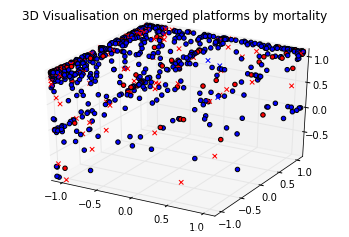

In [16]:
# visualization
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Tlab = np.zeros(len(y_tr))

# Iterate over all patients
# Plot their infos
for idx, id_idx in enumerate(patients_ixs_tr):
    patientid = patient_identifiers[id_idx]
    relapse = Rel[get_patient_idx_in_clas(patientid)] == 0
    mortality = Mrt[get_patient_idx_in_clas(patientid)] == 1
    i = idx
    
    if relapse:
        if mortality:
            ax.scatter(vinput[i,0], vinput[i,1], vinput[i,2], marker='x', c='b')
        else:
            ax.scatter(vinput[i,0], vinput[i,1], vinput[i,2], marker='o', c='b')
    else:
        if mortality:
            ax.scatter(vinput[i,0], vinput[i,1], vinput[i,2], marker='x', c='r')
            #ax.text(Data[i,0], Data[i,1], Data[i,2],  '%s' % (Plst[i]), size=8, zorder=1, color='k')
        else:
            ax.scatter(vinput[i,0], vinput[i,1], vinput[i,2], marker='o', c='r')
            #ax.text(Data[i,0], Data[i,1], Data[i,2],  '%s' % (Plst[i]), size=8, zorder=1, color='k')

ax.set_title("3D Visualisation on merged platforms by mortality")
plt.show()

In [7]:
# get_patient_idx("ALL460")
# "ALL460" in list(patient_identifiers)
# print(vinput[88])
# patients_sample_tr[:,0]

# get_patient_indexes()[3]
# print(np.where(patient_identifiers == map(lambda x: [patient_id_strip(x)], patients_sample_tr[:,0]) )[1])

# y = patients_sample_tr[:,0][0:10]

# def get_index_pat(patid):
#     try:
#         i = list(patient_identifiers).index(patid)
#         print(i)
#         return i
#     except:
#         print("Not found "+patid)
#         return None

# # map(get_index_pat, list(y))